So far we have explored the data for the Mercary price prediction and got some insight. Now, it's time for making some predictionn with machine learning and evaluate our algorithms.

###Step 1: Setting-up the environment and making all the preprocessing

**Step 1.1: Environment, Download and getting ready**

In [0]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [4]:
# Upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
#before importing the dataset we want to use this code
# The Kaggle API client expects this file to be in ~/.kaggle,
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c mercari-price-suggestion-challenge

 97% 286M/294M [00:03<00:00, 117MB/s]
100% 294M/294M [00:03<00:00, 95.6MB/s]
 93% 69.0M/74.3M [00:01<00:00, 35.8MB/s]
100% 74.3M/74.3M [00:01<00:00, 49.6MB/s]
 79% 27.0M/34.0M [00:00<00:00, 77.3MB/s]
100% 34.0M/34.0M [00:00<00:00, 134MB/s] 
  0% 0.00/170k [00:00<?, ?B/s]
100% 170k/170k [00:00<00:00, 174MB/s]
 64% 5.00M/7.77M [00:00<00:00, 49.1MB/s]
100% 7.77M/7.77M [00:00<00:00, 49.6MB/s]


In [7]:
# We unzip the downloaded .7z file
!apt-get install p7zip-full
!p7zip -d train.tsv.7z

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 77912192 bytes (75 MiB)

Extracting archive: train.tsv.7z
--
Path = train.tsv.7z
Type = 7z
Physical Size = 77912192
Headers Size = 122
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      3% - train.tsv                  7% - train.tsv                 11% - train.tsv                 14% - train.tsv                 18% - train.tsv                

**Step 1.2: Necessary Preprocessing**

In [0]:
# Importing:
import time
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split

from sklearn.linear_model import Ridge

In [10]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [11]:
#Load the data
df_price = pd.read_csv('train.tsv', sep = '\t').sample(frac=0.1).reset_index(drop=True)
df_price.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,1379757,NWT bare minerals make up case w/ mirror,1,Women/Women's Handbags/Cosmetic Bags,NaN,14.0,0,"8 x 5 x 2"" Message for bundle discounts"
1,628526,Reserved Vintage Bag,1,Women/Women's Handbags/Shoulder Bag,NaN,106.0,0,Reserved for buyer ✨ Next day shipping ✨
2,1016512,Chaps Boots,1,Women/Shoes/Boots,Chaps,25.0,1,"Dark Brown Boots , FREE SHIPPING"
3,232267,Love Pink headband,1,Women/Women's Accessories/Hair Accessories,Victoria's Secret,3.0,1,No description yet
4,1135383,Harley Davison Jeans 10L,2,Women/Jeans/Boot Cut,Harley-Davidson,12.0,0,"Bought from outlet, Harley Davidson NWOT jeans..."


In [12]:
%%time
#Necessary quick preprocessing on text data
df_price['category_name'] = df_price['category_name'].fillna('Other').astype(str)
df_price['brand_name'] = df_price['brand_name'].fillna('Non-branded').astype(str)
df_price['shipping'] = df_price['shipping'].astype(str) # We cannot use the shipping as nominal value.
df_price['item_condition_id'] = df_price['item_condition_id'].astype(str) # We cannot use the item condition as nominal value.
df_price['item_description'] = df_price['item_description'].fillna('No description provided')
df_price['price'] = np.log1p(df_price['price']) #converts the prices to log scale due to the skewed data

CPU times: user 288 ms, sys: 611 µs, total: 289 ms
Wall time: 292 ms


In [0]:
# Splitting the category
# Creating new Category Features
def seperate_categories(category_name):
  # We observe that most entries have three category names seperated by a backslash. 
  # If we do not find such, we will return the miscellaneous category.
    try:
        main_cat, sub_cat1, sub_cat2= category_name.split('/')
        return main_cat, sub_cat1, sub_cat2
    except:
        return 'Other','Other','Other'
    
df_price['category_main'], df_price['category_sub1'], df_price['category_sub2'] = zip(*df_price['category_name'].apply(seperate_categories))
df_price.drop('category_name', axis=1, inplace=True)

In [14]:
df_price.head()

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,category_main,category_sub1,category_sub2
0,1379757,NWT bare minerals make up case w/ mirror,1,Non-branded,2.708050,0,"8 x 5 x 2"" Message for bundle discounts",Women,Women's Handbags,Cosmetic Bags
1,628526,Reserved Vintage Bag,1,Non-branded,4.672829,0,Reserved for buyer ✨ Next day shipping ✨,Women,Women's Handbags,Shoulder Bag
2,1016512,Chaps Boots,1,Chaps,3.258097,1,"Dark Brown Boots , FREE SHIPPING",Women,Shoes,Boots
3,232267,Love Pink headband,1,Victoria's Secret,1.386294,1,No description yet,Women,Women's Accessories,Hair Accessories
4,1135383,Harley Davison Jeans 10L,2,Harley-Davidson,2.564949,0,"Bought from outlet, Harley Davidson NWOT jeans...",Women,Jeans,Boot Cut


###**step 2**: Create a function to quantify the model performance

In [0]:
# Definte function to calculate root-mean-squared-log-error (RMSLE) with kfold cross validation (5 fold)
from sklearn.model_selection import KFold, cross_val_score, train_test_split
def rmsle(model):
    folds = KFold(shuffle=True, random_state=42).get_n_splits(df_price['item_description'])
    rmse= np.sqrt(-cross_val_score(model, df_price['item_description'], df_price['price'], scoring="neg_mean_squared_error", cv = folds))
    return rmse.mean()

### Step 3: Select a good baseline model

We will try out different ways to select a good baseline model

**Step 3.a : Create a simple baseline with item description and using countvectorizer method**

In [21]:
%%time
from sklearn.linear_model import Ridge

vec = CountVectorizer(ngram_range=(1,2))
clf = Ridge(random_state=42)
pipe_base1 = make_pipeline(vec, clf)
pipe_base1.fit(df_price['item_description'], df_price['price'])

cv_rmsle = rmsle(pipe_base1)

print("The Validation Score is: " + str(cv_rmsle))

The Validation Score is: 0.7230240651292319
CPU times: user 7min 51s, sys: 4min 44s, total: 12min 36s
Wall time: 6min 52s


This seems too high. We can visualize the performance with the eli5 visulizer

In [22]:
!pip install eli5

     |████████████████████████████████| 112kB 9.2MB/s 


In [23]:
import eli5
eli5.show_weights(pipe_base1, vec=vec, top=20, feature_filter=lambda x: x != '<BIAS>')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


Weight?,Feature
+2.113,chanel purse
+1.557,vuitton backpack
+1.391,negotiable let
+1.299,adult bracelet
+1.243,halloween sale
+1.225,negotiable some
+1.183,brown tote
+1.176,gold at
+1.152,for ckinman
+1.152,ckinman


In [25]:
eli5.show_prediction(clf, doc=df_price['item_description'][110], vec=vec)

We can well visualize that the model performance is not so good, as it is putting negative weight in positive words.

In [26]:
from sklearn.linear_model import Ridge

vec = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
clf = Ridge(random_state=42)
pipe_base2 = make_pipeline(vec, clf)
pipe_base2.fit(df_price['item_description'], df_price['price'])

cv_rmsle = rmsle(pipe_base2)

print("The Validation Score is: " + str(cv_rmsle))

The Validation Score is: 0.6086376174989386


Using tf-idf provides great imporvement over countvectorizer method. Therefore, we can keep it. Let's build some visualization around the method:

In [27]:
eli5.show_weights(pipe_base2, vec=vec, top=20, feature_filter=lambda x: x != '<BIAS>')

Weight?,Feature
+3.723,unlocked
+2.794,imei
+2.584,receipt
+2.423,date code
+2.414,14k
+2.408,gb
+2.338,32gb
+2.311,16gb
+2.244,lv
+2.211,carrier


In [28]:
eli5.show_prediction(clf, doc=df_price['item_description'][10], vec=vec)

### Step 4: Build a model using all the features by combining them


In [0]:
from sklearn.pipeline import FeatureUnion

default_preprocessor = CountVectorizer().build_preprocessor()

def build_preprocessor(field):
    field_idx = list(df_price.columns).index(field)
    return lambda x: default_preprocessor(x[field_idx])

vectorizer = FeatureUnion([
    ('name', CountVectorizer(
        ngram_range=(1, 2),
        max_features=50000,
        preprocessor=build_preprocessor('name'))),
    ('category_main', CountVectorizer(
        token_pattern='.+',
        preprocessor=build_preprocessor('category_main'))),
    ('category_sub1', CountVectorizer(
        token_pattern='.+',
        preprocessor=build_preprocessor('category_sub1'))),
    ('category_sub2', CountVectorizer(
        token_pattern='.+',
        preprocessor=build_preprocessor('category_sub2'))),
    ('brand_name', CountVectorizer(
        token_pattern='.+',
        preprocessor=build_preprocessor('brand_name'))),
    ('shipping', CountVectorizer(
        token_pattern='\d+',
        preprocessor=build_preprocessor('shipping'))),
    ('item_condition_id', CountVectorizer(
        token_pattern='\d+',
        preprocessor=build_preprocessor('item_condition_id'))),
    ('item_description', TfidfVectorizer(
        ngram_range=(1, 2),
        max_features=55000,
        stop_words='english',
        preprocessor=build_preprocessor('item_description'))),
])

In [17]:
# Create Transformed Train Set
train_transformed = vectorizer.fit_transform(df_price.values)
train_transformed

<148254x108177 sparse matrix of type '<class 'numpy.float64'>'
	with 4942839 stored elements in Compressed Sparse Row format>

First, let's define the Root-mean-squared-log-error (RMSLE).

In [0]:
def RMSLE_calculate(y, pred): 
    return np.sqrt(mean_squared_error(y, pred))


**let's try with ridge regression and LASSO regression.**

In [34]:
%%time
from sklearn.linear_model import Lasso


# Create 3-Fold CV
cv = KFold(n_splits=3, shuffle=True, random_state=42)
for train_ids, valid_ids in cv.split(train_transformed):
    # Define Ridge Model
    model_ridge = Ridge(solver = "lsqr", fit_intercept=False, random_state=42)
    model_lasso = Lasso(fit_intercept=False, random_state=42)
    
    # Fit Ridge and lasso Model
    model_ridge.fit(train_transformed[train_ids], df_price['price'][train_ids])
    model_lasso.fit(train_transformed[train_ids], df_price['price'][train_ids])
    
    # Predict & Evaluate Training Score for ridge
    y_pred_train_ridge = model_ridge.predict(train_transformed[train_ids])
    rmsle_train_ridge = RMSLE_calculate(y_pred_train_ridge, df_price['price'][train_ids])
    
    # Predict & Evaluate Training Score for Lasso
    y_pred_train_lasso = model_lasso.predict(train_transformed[train_ids])
    rmsle_train_lasso = RMSLE_calculate(y_pred_train_lasso, df_price['price'][train_ids])
    
    # Predict & Evaluate Validation Score  for ridge
    y_pred_valid_ridge = model_ridge.predict(train_transformed[valid_ids])
    rmsle_valid_ridge = RMSLE_calculate(y_pred_valid_ridge, df_price['price'][valid_ids])
    
    # Predict & Evaluate Validation Score  for lasso
    y_pred_valid_lasso = model_lasso.predict(train_transformed[valid_ids])
    rmsle_valid_lasso = RMSLE_calculate(y_pred_valid_lasso, df_price['price'][valid_ids])
    
    print(f'Ridge Training RMSLE: {rmsle_train_ridge:.5f}')
    print(f'Ridge Validation RMSLE: {rmsle_valid_ridge:.5f}')
    print(f'Lasso Training RMSLE: {rmsle_train_lasso:.5f}')
    print(f'Lasso Validation RMSLE: {rmsle_valid_lasso:.5f}')


Ridge Training RMSLE: 0.31730
Ridge Validation RMSLE: 0.52054
Lasso Training RMSLE: 2.13803
Lasso Validation RMSLE: 2.13506
Ridge Training RMSLE: 0.31900
Ridge Validation RMSLE: 0.51719
Lasso Training RMSLE: 2.13781
Lasso Validation RMSLE: 2.14536
Ridge Training RMSLE: 0.31684
Ridge Validation RMSLE: 0.52198
Lasso Training RMSLE: 2.13931
Lasso Validation RMSLE: 2.13479
CPU times: user 12.4 s, sys: 9.33 s, total: 21.8 s
Wall time: 11.3 s


It's pretty clear that, lasso is way worse than Ridge and thus, we only choose ridge.

What about **Light-GBM**?

In [19]:
!pip install lightgbm

In [36]:
%%time
import lightgbm as lgb

for train_ids, valid_ids in cv.split(train_transformed):
    # Define LGBM Model
    model_lgb = lgb.LGBMRegressor(num_leaves=31, n_jobs=-1, learning_rate=0.1, n_estimators=500, random_state=42)
    
    # Fit LGBM Model
    model_lgb.fit(train_transformed[train_ids], df_price['price'][train_ids])
    
    # Predict & Evaluate Training Score
    y_pred_train = model_lgb.predict(train_transformed[train_ids])
    rmsle_train = RMSLE_calculate(y_pred_train, df_price['price'][train_ids])
    
    # Predict & Evaluate Validation Score
    y_pred_valid = model_lgb.predict(train_transformed[valid_ids])
    rmsle_valid = RMSLE_calculate(y_pred_valid, df_price['price'][valid_ids])
    
    print(f'LGBM Training RMSLE: {rmsle_train:.5f}')
    print(f'LGBM Validation RMSLE: {rmsle_valid:.5f}')
    

LGBM Training RMSLE: 0.46173
LGBM Validation RMSLE: 0.50928
LGBM Training RMSLE: 0.46047
LGBM Validation RMSLE: 0.51055
LGBM Training RMSLE: 0.46067
LGBM Validation RMSLE: 0.50995
CPU times: user 25min 49s, sys: 1.27 s, total: 25min 51s
Wall time: 13min 5s


So, we have found the Light GBM model quite comparable with Ridge regression. Now, can we come up with an ensemble model with these 2 and build a better one ? 

### Step 4: Building an ensemble model and beat our baseline score

The following code helps to search the best num_leaves in LGBM

In [0]:
%%time

#Building an optimized light-gbm model
num_leaves = [20, 30, 40, 50]
for leaf in num_leaves:
    CV_rmsle = []
    for train_ids, valid_ids in folds.split(train_transformed):
        # Define LGBM Model
        model_lgb = lgb.LGBMRegressor(num_leaves=leaf, n_jobs=-1, learning_rate=0.1, n_estimators=500, random_state=42)

        # Fit LGBM Model
        model_lgb.fit(train_transformed[train_ids], df_price['price'][train_ids])

        # Predict & Evaluate Training Score
        y_pred_train = model_lgb.predict(train_transformed[train_ids])
        rmsle_train = RMSLE_calculate(y_pred_train, df_price['price'][train_ids])

        # Predict & Evaluate Validation Score
        y_pred_valid = model_lgb.predict(train_transformed[valid_ids])
        rmsle_valid = RMSLE_calculate(y_pred_valid, df_price['price'][valid_ids])
        CV_rmsle.append(rmsle_valid)
    print('Average cross validation rmsle for {} leaves is {:.2f}'.format(leaf, np.mean(CV_rmsle)))

In [0]:
def mean_pred(y_pred1, y_pred2):
    return (y_pred1+y_pred2)/2

In [27]:
#Building an ensemble model: 
leaf = 30 #decide it
for train_ids, valid_ids in cv.split(train_transformed):
    # Define Ridge Model
    model_ridge = Ridge(solver = "lsqr", fit_intercept=False, random_state=42)
    model_lgbm =  lgb.LGBMRegressor(num_leaves=leaf, n_jobs=-1, learning_rate=0.1, n_estimators=500, random_state=42)
    
    # Fit Ridge and LGBM Model
    model_ridge.fit(train_transformed[train_ids], df_price['price'][train_ids])
    model_lgbm.fit(train_transformed[train_ids], df_price['price'][train_ids])
    
    # Predict & Evaluate Training Score for ensemble
    y_pred_train_ridge = model_ridge.predict(train_transformed[train_ids])
    y_pred_train_lgbm = model_lgbm.predict(train_transformed[train_ids])
    rmsle_train_ensemble = RMSLE_calculate(mean_pred(y_pred_train_ridge, y_pred_train_lgbm), df_price['price'][train_ids])
    
    # Predict & Evaluate Validation Score  for ensemble
    y_pred_valid_ridge = model_ridge.predict(train_transformed[valid_ids])
    y_pred_valid_lgbm = model_lgbm.predict(train_transformed[valid_ids])
    rmsle_valid_ensemble = RMSLE_calculate(mean_pred(y_pred_valid_ridge, y_pred_valid_lgbm), df_price['price'][valid_ids])
    
    print(f'Ensemble Training RMSLE: {rmsle_train_ensemble:.5f}')
    print(f'Ensemble Validation RMSLE: {rmsle_valid_ensemble:.5f}')


Ensemble Training RMSLE: 0.36676
Ensemble Validation RMSLE: 0.48531
Ensemble Training RMSLE: 0.36609
Ensemble Validation RMSLE: 0.48613
Ensemble Training RMSLE: 0.36642
Ensemble Validation RMSLE: 0.48442


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
df_performance = pd.DataFrame()
df_performance['Models'] = ['baseline_score', 'combined_ridge_regression', 'combined_LGBM', 'Ensemble']
df_performance['RMSLE'] = [0.61, 0.52, 0.51, 0.48]
df_performance.set_index('Models', drop=True, inplace=True)

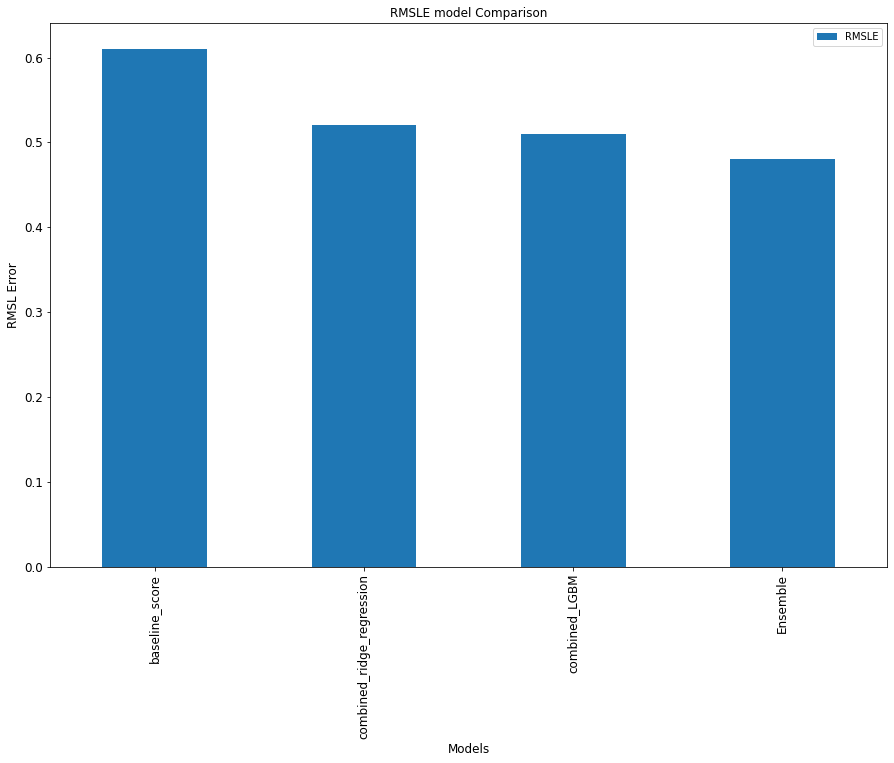

In [47]:
ax = df_performance['RMSLE'].plot(kind='bar', title ="RMSLE model Comparison", figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("Models", fontsize=12)
ax.set_ylabel("RMSL Error", fontsize=12)
plt.show()